In [3]:
# Gerekli kütüphaneleri içe aktar
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Veri yolları
meteor_path = "../data/meteorite-landings.csv"
cities_path = "../data/ne_10m_populated_places/ne_10m_populated_places.shp"

# Meteor verisini yükle
meteor_df = pd.read_csv(meteor_path)
print("Meteor verisi:")
display(meteor_df.head())

# Yerleşim yeri verisini yükle
cities_gdf = gpd.read_file(cities_path)
print("Yerleşim verisi:")
display(cities_gdf.head())


Meteor verisi:


,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.216670, -113.000000)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.883330, -99.900000)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)"


Yerleşim verisi:


,SCALERANK,NATSCALE,LABELRANK,FEATURECLA,NAME,NAMEPAR,NAMEALT,NAMEASCII,ADM0CAP,CAPIN,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
0,10,1,8.0,Admin-1 capital,Colonia del Sacramento,None,None,Colonia del Sacramento,0,None,...,None,None,None,None,None,None,None,None,None,POINT (-57.83612 -34.46979)
1,10,1,8.0,Admin-1 capital,Trinidad,None,None,Trinidad,0,None,...,None,None,None,None,None,None,None,None,None,POINT (-56.901 -33.544)
2,10,1,8.0,Admin-1 capital,Fray Bentos,None,None,Fray Bentos,0,None,...,None,None,None,None,None,None,None,None,None,POINT (-58.304 -33.139)
3,10,1,8.0,Admin-1 capital,Canelones,None,None,Canelones,0,None,...,None,None,None,None,None,None,None,None,None,POINT (-56.284 -34.538)
4,10,1,8.0,Admin-1 capital,Florida,None,None,Florida,0,None,...,None,None,None,None,None,None,None,None,None,POINT (-56.215 -34.099)


In [4]:
meteor_df.isnull().sum()


name              0
id                0
nametype          0
recclass          0
mass            131
fall              0
year            288
reclat         7315
reclong        7315
GeoLocation    7315
dtype: int64

In [18]:
# Ülke bilgisi içeren sütunu kontrol ederek Türkiye şehirlerini filtrele
if "ADM0NAME" in cities_gdf.columns:
    turkiye_sehirleri = cities_gdf[cities_gdf["ADM0NAME"] == "Turkey"]
elif "ISO_A2" in cities_gdf.columns:
    turkiye_sehirleri = cities_gdf[cities_gdf["ISO_A2"] == "TR"]
else:
    raise ValueError("Türkiye'yi tanımlamak için uygun sütun bulunamadı.")

# Sonuçları görüntüle: şehir adı, nüfus, ülke
display(
    turkiye_sehirleri[["NAME", "POP_MAX", "ADM0NAME"]]
    .sort_values("POP_MAX", ascending=False)
    .reset_index(drop=True)
)


,NAME,POP_MAX,ADM0NAME
0,Istanbul,10061000,Turkey
1,Ankara,3716000,Turkey
2,İzmir,2587000,Turkey
3,Bursa,1492000,Turkey
4,Adana,1293000,Turkey
...,...,...,...
78,Bilecik,40285,Turkey
79,Sinop,34834,Turkey
80,Artvin,32272,Turkey
81,Gümüşhane,32250,Turkey


In [5]:
print(f"Meteor veri setinde toplam {len(meteor_df)} satır var.")


Meteor veri setinde toplam 45716 satır var.


In [6]:
# Koordinat bilgisi eksik olanları veri setinden çıkaralım
meteor_clean = meteor_df.dropna(subset=['reclat', 'reclong']).copy()

# Kaç satır kaldı?
print(f"Koordinat içeren meteor sayısı: {len(meteor_clean)}")


Koordinat içeren meteor sayısı: 38401


In [7]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# GeoLocation sütunu dolu olanları al
meteor_df_geo = meteor_df.dropna(subset=['GeoLocation']).copy()

# GeoLocation'dan enlem ve boylamı ayır
meteor_df_geo[['lat_from_geo', 'lon_from_geo']] = (
    meteor_df_geo['GeoLocation']
    .str.replace('[()]', '', regex=True)       # Parantezleri temizle
    .str.split(',', expand=True)               # Virgülden ayır
    .astype(float)                             # Float'a çevir
)

# GeoDataFrame oluştur
geometry = [Point(xy) for xy in zip(meteor_df_geo["lon_from_geo"], meteor_df_geo["lat_from_geo"])]
meteor_gdf = gpd.GeoDataFrame(meteor_df_geo, geometry=geometry, crs="EPSG:4326")

print(f"GeoLocation üzerinden elde edilen kayıt sayısı: {len(meteor_gdf)}")


GeoLocation üzerinden elde edilen kayıt sayısı: 38401


C:\Users\yalaz\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


<Axes: >

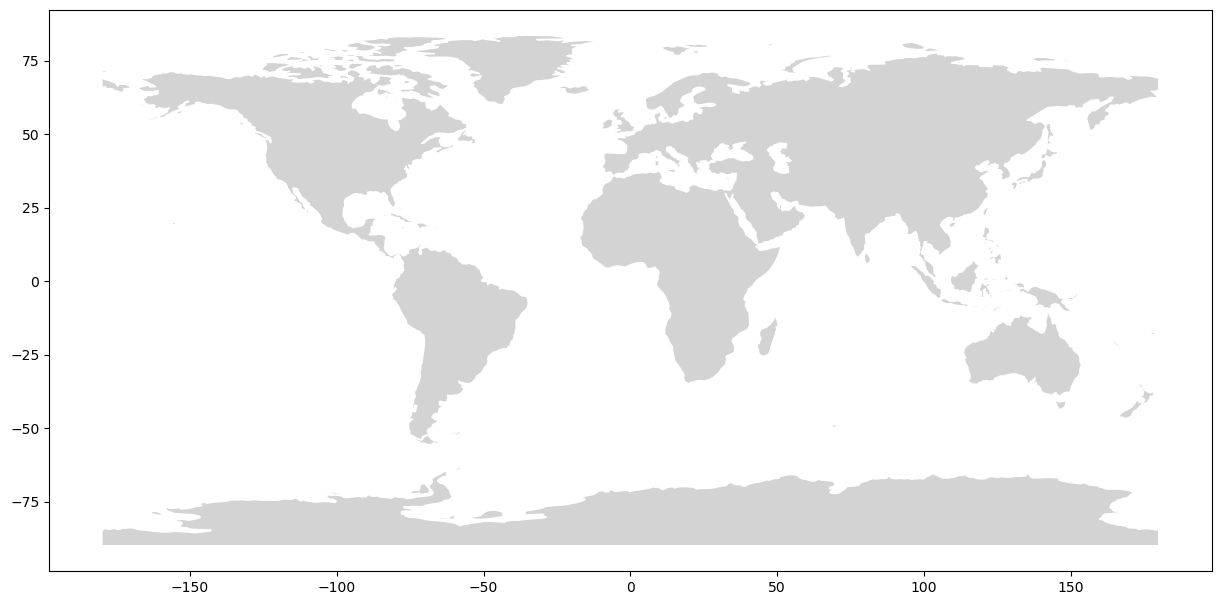

In [8]:
import geopandas as gpd
import geodatasets

# Dünya haritası veri setini yükle
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# Görselleştir
world.plot(figsize=(15, 10), color='lightgrey', edgecolor='white')


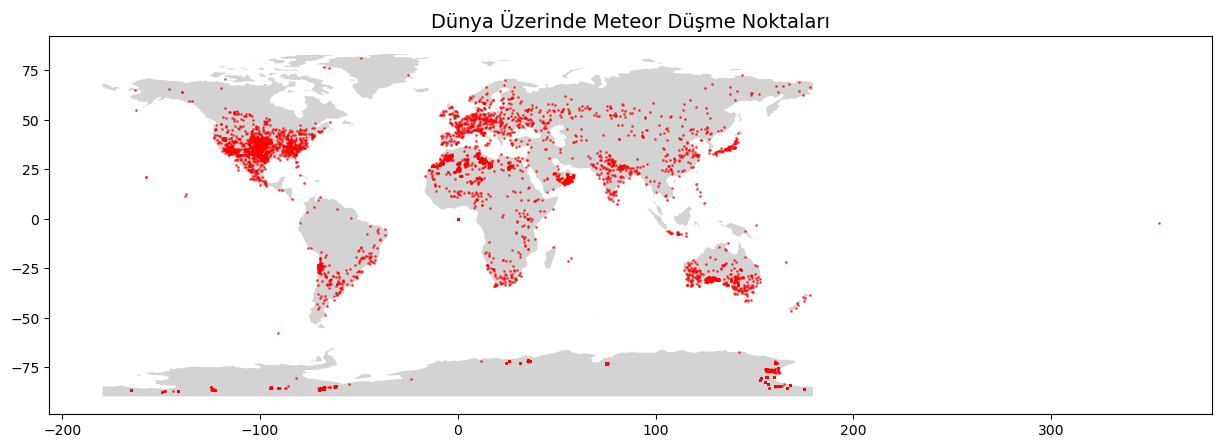

In [9]:
import matplotlib.pyplot as plt
import geopandas as gpd
import geodatasets

# Dünya haritasını yükle
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# Haritayı çiz
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Meteor düşme noktalarını ekle
meteor_gdf.plot(ax=ax, markersize=1, color='red', alpha=0.6)

# Başlık ve göster
plt.title("Dünya Üzerinde Meteor Düşme Noktaları", fontsize=14)
plt.show()


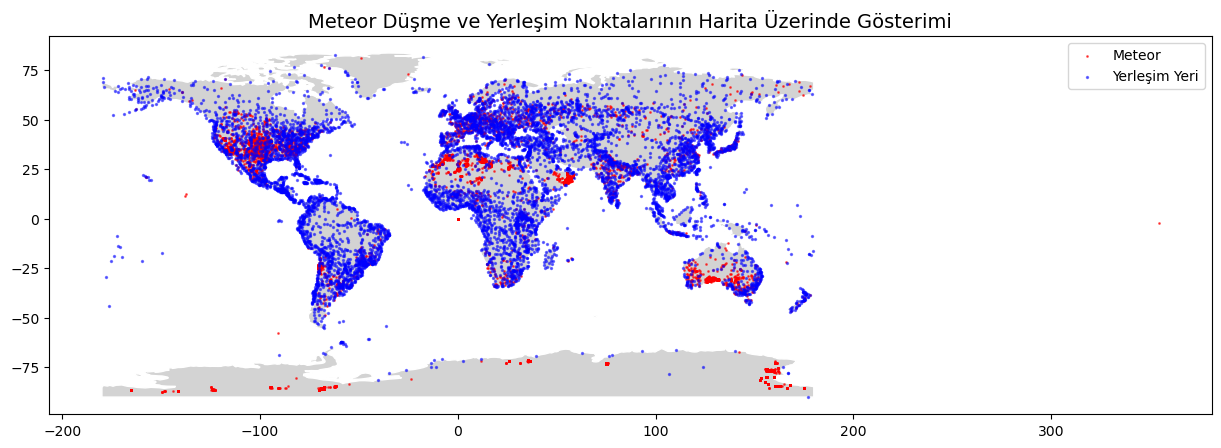

In [10]:
# Harita oluştur
fig, ax = plt.subplots(figsize=(15, 10))

# Dünya haritası
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Meteor düşme noktaları (kırmızı)
meteor_gdf.plot(ax=ax, markersize=1, color='red', alpha=0.6, label='Meteor')

# Yerleşim noktaları (mavi)
cities_gdf.plot(ax=ax, markersize=2, color='blue', alpha=0.5, label='Yerleşim Yeri')

# Başlık ve göster
plt.title("Meteor Düşme ve Yerleşim Noktalarının Harita Üzerinde Gösterimi", fontsize=14)
plt.legend()
plt.show()


In [11]:
from shapely.ops import nearest_points
from tqdm import tqdm

# Projeksiyon dönüşümü (metrik sistem)
meteor_proj = meteor_gdf.to_crs(epsg=3857)
cities_proj = cities_gdf.to_crs(epsg=3857)

# En yakın meteor mesafesini hesaplamak için bir fonksiyon
def nearest_meteor_distance(city_point, meteor_points):
    nearest_geom = meteor_points.geometry.distance(city_point).min()
    return nearest_geom

# Her şehir için en yakın meteor mesafesini hesapla
tqdm.pandas()
cities_proj['min_meteor_distance_m'] = cities_proj.geometry.progress_apply(lambda x: nearest_meteor_distance(x, meteor_proj))


100%|█████████████████████████████████████████████████████████████████████████████| 7342/7342 [00:09<00:00, 756.77it/s]


In [12]:
cities_proj[['NAME', 'min_meteor_distance_m']].sort_values('min_meteor_distance_m').head(10)


,NAME,min_meteor_distance_m
5165,Baruun-Urt,4.427769
5516,Holman,13.161528
211,Qacha's Nek,235.465772
6996,Varanasi,272.980783
6797,Pittsburgh,295.429939
5186,Denpasar,369.027328
6349,Stavropol,369.480543
5444,Sfax,371.492621
3606,Osnabrück,526.232179
726,Lafayette,571.215630


In [13]:
cities_proj['min_meteor_distance_m'].describe()


count    7.342000e+03
mean     3.048099e+05
std      1.335445e+06
min      4.427769e+00
25%      7.463368e+04
50%      1.541839e+05
75%      3.151812e+05
max      1.077382e+08
Name: min_meteor_distance_m, dtype: float64

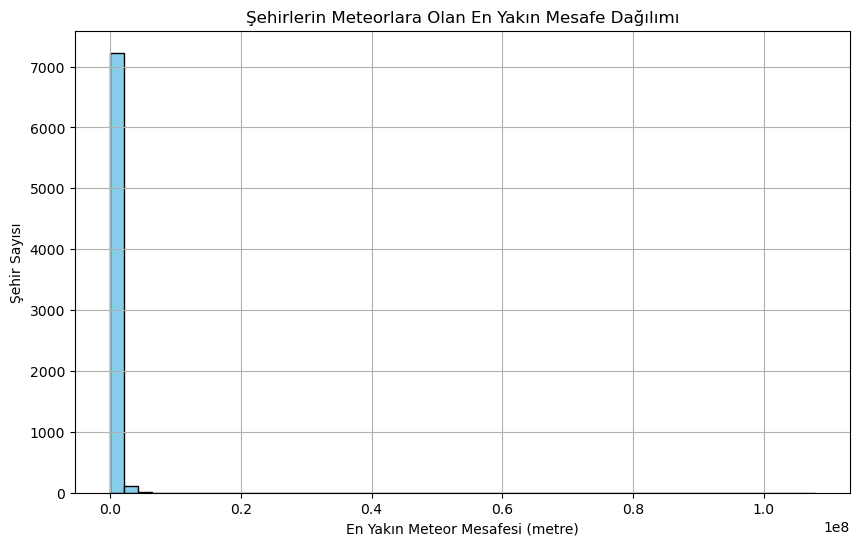

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
cities_proj['min_meteor_distance_m'].hist(bins=50, color='skyblue', edgecolor='black')
plt.xlabel('En Yakın Meteor Mesafesi (metre)')
plt.ylabel('Şehir Sayısı')
plt.title('Şehirlerin Meteorlara Olan En Yakın Mesafe Dağılımı')
plt.grid(True)
plt.show()


In [15]:
cities_proj[cities_proj['min_meteor_distance_m'] < 500_000].shape[0]


6277

In [16]:
yakindaki_sehirler = cities_proj[cities_proj['min_meteor_distance_m'] < 500_000].shape[0]
toplam_sehir = cities_proj.shape[0]

oran = yakindaki_sehirler / toplam_sehir
print(f"500 km'den daha yakında olan şehir oranı: %{oran * 100:.2f}")


500 km'den daha yakında olan şehir oranı: %85.49


In [17]:
# Mesafe eşikleri (metre cinsinden)
mesafeler = [50_000, 100_000, 150_000, 200_000, 250_000, 300_000, 400_000, 500_000]

# Toplam şehir sayısı
toplam_sehir = cities_proj.shape[0]

# Her eşik için oran hesapla ve yazdır
for m in mesafeler:
    yakindaki_sehirler = cities_proj[cities_proj['min_meteor_distance_m'] < m].shape[0]
    oran = yakindaki_sehirler / toplam_sehir
    print(f"{m//1000} km'den daha yakında olan şehir oranı: %{oran * 100:.2f}")


50 km'den daha yakında olan şehir oranı: %15.15
100 km'den daha yakında olan şehir oranı: %34.09
150 km'den daha yakında olan şehir oranı: %49.07
200 km'den daha yakında olan şehir oranı: %59.48
250 km'den daha yakında olan şehir oranı: %67.37
300 km'den daha yakında olan şehir oranı: %73.40
400 km'den daha yakında olan şehir oranı: %81.11
500 km'den daha yakında olan şehir oranı: %85.49


Avrupa'daki şehir sayısı: 1197


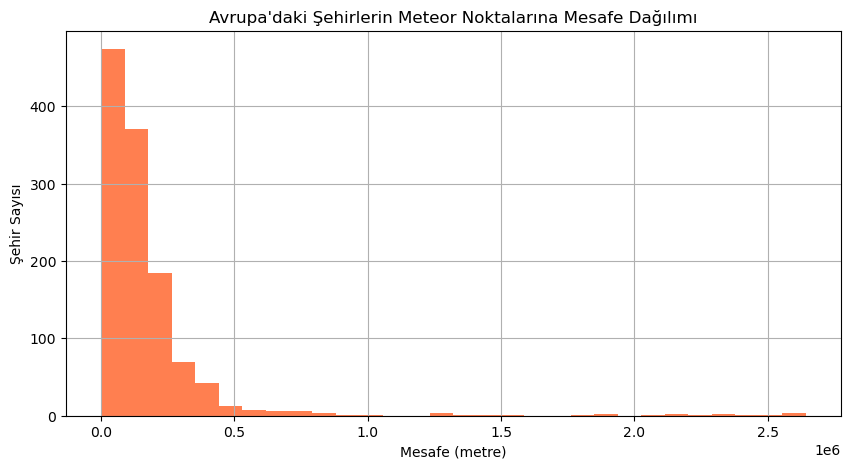

In [15]:
# Koordinat sistemini tekrar EPSG:4326'ya çevir
cities_deg = cities_proj.to_crs(epsg=4326)

# Avrupa kıtasını yaklaşık kapsayan filtre
cities_europe = cities_deg[
    (cities_deg.geometry.x >= -30) & 
    (cities_deg.geometry.x <= 50) & 
    (cities_deg.geometry.y >= 35) & 
    (cities_deg.geometry.y <= 70)
]

# Kontrol et: şehir sayısı
print(f"Avrupa'daki şehir sayısı: {len(cities_europe)}")

# Histogram
cities_europe['min_meteor_distance_m'].hist(bins=30, figsize=(10, 5), color='coral')
plt.title("Avrupa'daki Şehirlerin Meteor Noktalarına Mesafe Dağılımı")
plt.xlabel("Mesafe (metre)")
plt.ylabel("Şehir Sayısı")
plt.grid(True)
plt.show()


Asya'daki şehir sayısı: 1682


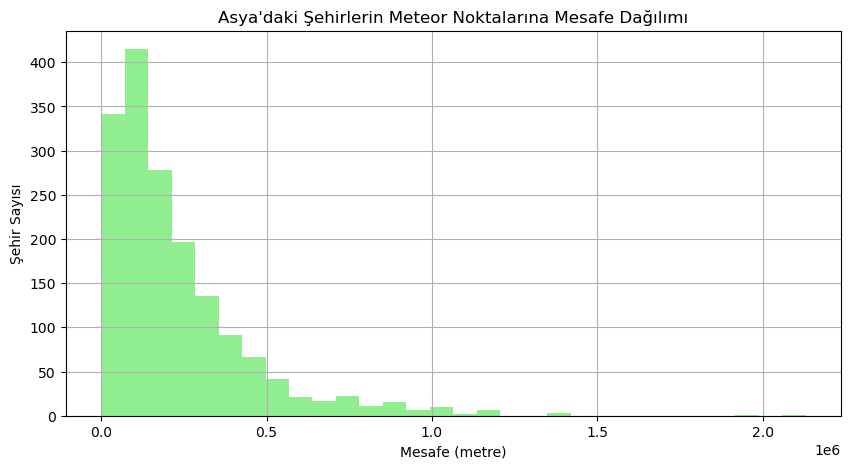

In [16]:
# Asya yaklaşık koordinat aralığı
cities_asia = cities_deg[
    (cities_deg.geometry.x >= 50) & 
    (cities_deg.geometry.x <= 150) & 
    (cities_deg.geometry.y >= 0) & 
    (cities_deg.geometry.y <= 60)
]

print(f"Asya'daki şehir sayısı: {len(cities_asia)}")

cities_asia['min_meteor_distance_m'].hist(bins=30, figsize=(10, 5), color='lightgreen')
plt.title("Asya'daki Şehirlerin Meteor Noktalarına Mesafe Dağılımı")
plt.xlabel("Mesafe (metre)")
plt.ylabel("Şehir Sayısı")
plt.grid(True)
plt.show()


Kuzey Amerika'daki şehir sayısı: 1458


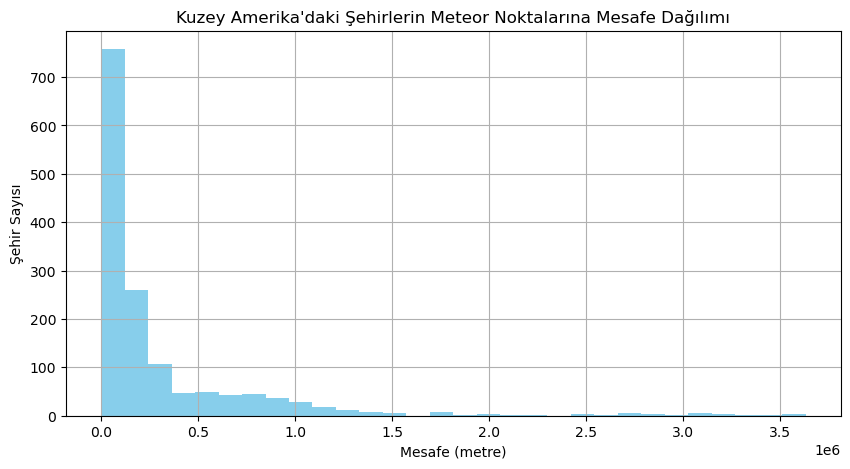

In [17]:
# Kuzey Amerika yaklaşık aralığı
cities_na = cities_deg[
    (cities_deg.geometry.x >= -170) & 
    (cities_deg.geometry.x <= -30) & 
    (cities_deg.geometry.y >= 10) & 
    (cities_deg.geometry.y <= 80)
]

print(f"Kuzey Amerika'daki şehir sayısı: {len(cities_na)}")

cities_na['min_meteor_distance_m'].hist(bins=30, figsize=(10, 5), color='skyblue')
plt.title("Kuzey Amerika'daki Şehirlerin Meteor Noktalarına Mesafe Dağılımı")
plt.xlabel("Mesafe (metre)")
plt.ylabel("Şehir Sayısı")
plt.grid(True)
plt.show()


Afrika'daki şehir sayısı: 1364


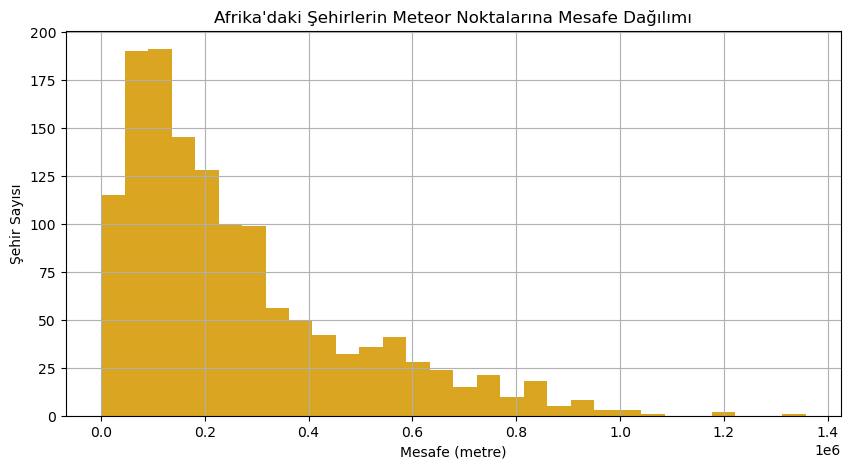

In [18]:
# Afrika yaklaşık aralığı
cities_africa = cities_deg[
    (cities_deg.geometry.x >= -20) & 
    (cities_deg.geometry.x <= 50) & 
    (cities_deg.geometry.y >= -35) & 
    (cities_deg.geometry.y <= 35)
]

print(f"Afrika'daki şehir sayısı: {len(cities_africa)}")

cities_africa['min_meteor_distance_m'].hist(bins=30, figsize=(10, 5), color='goldenrod')
plt.title("Afrika'daki Şehirlerin Meteor Noktalarına Mesafe Dağılımı")
plt.xlabel("Mesafe (metre)")
plt.ylabel("Şehir Sayısı")
plt.grid(True)
plt.show()


C:\Users\yalaz\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\yalaz\AppData\Local\Temp\ipykernel_14152\951822549.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  space_cmap = plt.cm.get_cmap("plasma", 8)  # Alternatifler: "twilight", "magma", "inferno"


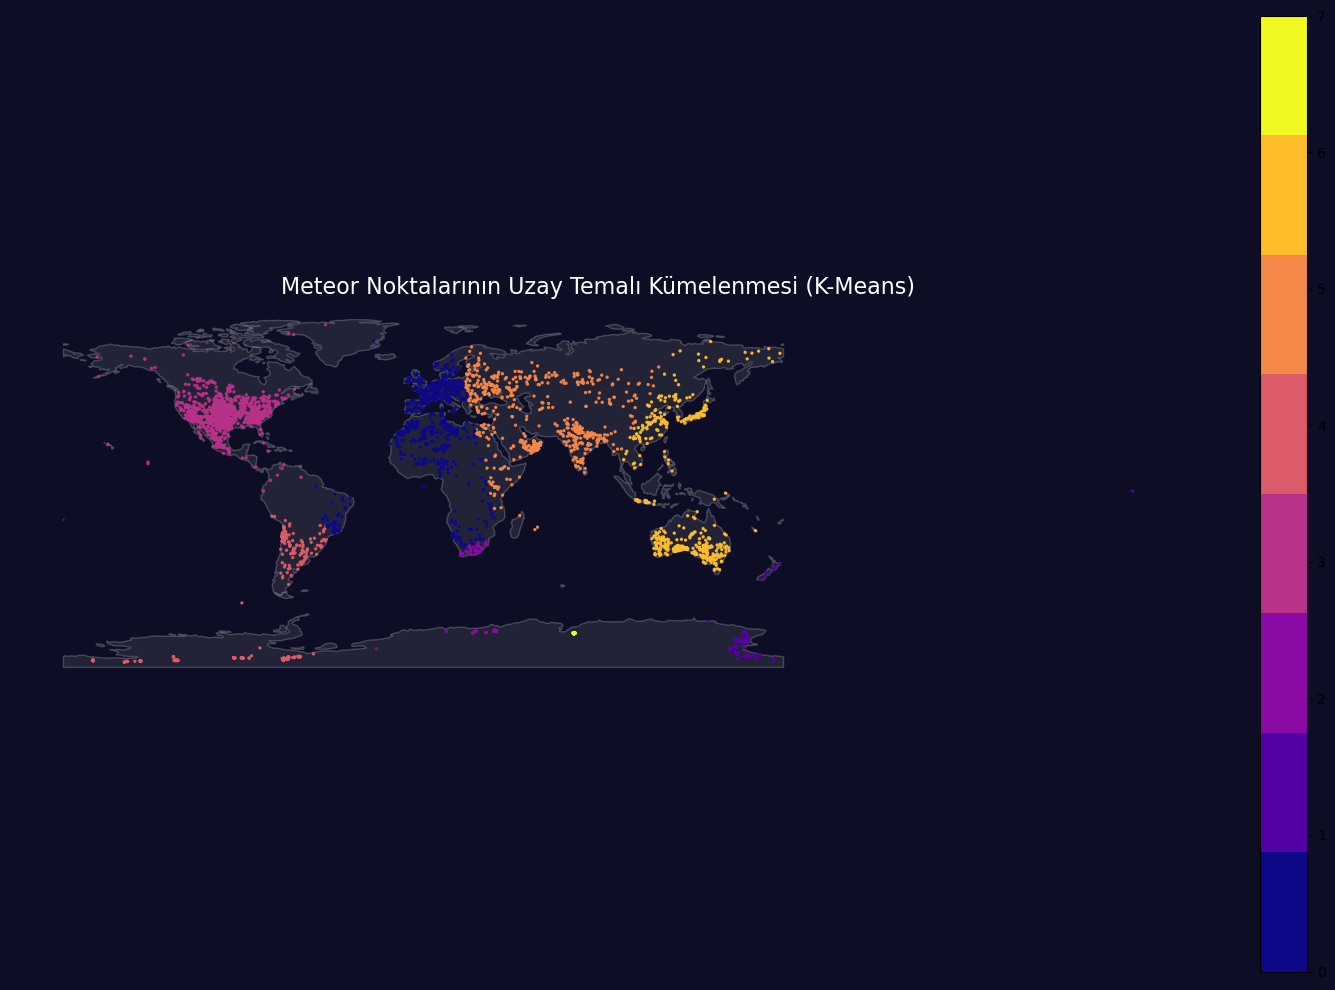

In [19]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# 1. Meteor koordinatlarını numpy dizisine çevir
# (longitude, latitude) yani (x, y) olarak alınır
meteor_coords = np.array(list(zip(meteor_gdf.geometry.x, meteor_gdf.geometry.y)))

# 2. KMeans modelini oluştur (örnek: 8 küme)
kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(meteor_coords)

# 3. Sonuçları GeoDataFrame'e ekle
meteor_gdf['cluster'] = clusters

# 4. Uzay temalı renk paleti (mor, lacivert tonları)
space_cmap = plt.cm.get_cmap("plasma", 8)  # Alternatifler: "twilight", "magma", "inferno"

# 5. Dünya haritası katmanını yükle
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# 6. Haritayı çiz
fig, ax = plt.subplots(figsize=(15, 10))
fig.patch.set_facecolor('#0d0d26')  # Harita arka planı: çok koyu lacivert

# Dünya haritasını açık gri ile çiz
world.plot(ax=ax, color='gray', edgecolor='white', alpha=0.2)

# Meteor kümelerini çiz (uzay renkleri)
meteor_gdf.plot(ax=ax, column='cluster', cmap=space_cmap, markersize=2, alpha=0.9, legend=True)

# Başlık ve görsel ayarlar
plt.title("Meteor Noktalarının Uzay Temalı Kümelenmesi (K-Means)", fontsize=16, color='white')
ax.set_facecolor('#0d0d26')  # Eksen arka planı da uzay tonunda
ax.tick_params(colors='white')  # Eksen yazıları beyaz
plt.grid(False)
plt.axis('off')  # Harita çerçevesi kaldırılır
plt.tight_layout()
plt.show()


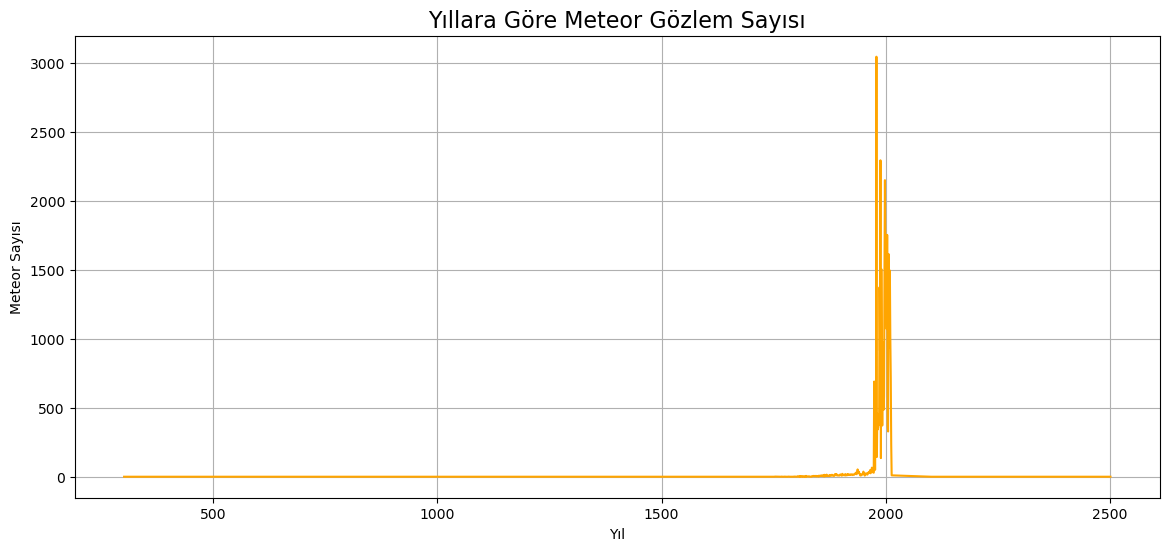

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Yıl bilgisini sayısal formata çevir
# Bazı kayıtlar eksik ya da hatalı olabilir, bunları NaN yapıyoruz
meteor_gdf['year'] = pd.to_numeric(meteor_gdf['year'], errors='coerce')

# 2️⃣ Geçerli yıl bilgisi olan kayıtları al
meteor_time = meteor_gdf.dropna(subset=['year']).copy()

# 3️⃣ Yıl değerini tam sayıya çevir
meteor_time['year'] = meteor_time['year'].astype(int)

# 4️⃣ Grupla ve yıllara göre meteor sayısını hesapla
yearly_counts = meteor_time.groupby('year').size()

# 5️⃣ Zaman serisi grafiğini çiz
plt.figure(figsize=(14, 6))
yearly_counts.plot(kind='line', color='orange')
plt.title("Yıllara Göre Meteor Gözlem Sayısı", fontsize=16)
plt.xlabel("Yıl")
plt.ylabel("Meteor Sayısı")
plt.grid(True)
plt.show()
